# RehabModel

This notebook loads the combined data, and models the mortality rate.

In [26]:
%matplotlib inline

from bs4 import BeautifulSoup
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import ensemble
from sklearn import linear_model
import scipy as sp
import seaborn as sns
import string
import requests
import time

In [3]:
with open('DataCombined.json', 'r') as f:
    d = json.load(f);

df = pd.DataFrame(d);
df.index = df.index.astype(int);
df.sort_index(inplace=True);
print df.dtypes
df.head()

County                                                           object
Death Rate Category Median                                      float64
Estimated Age-adjusted Death Rate, 11 Categories (in ranges)     object
FIPS                                                            float64
FIPS State                                                      float64
Opioid Claims                                                   float64
Opioid Prescribing Rate                                         float64
Overall Claims                                                  float64
Part D Prescribers                                              float64
Population                                                      float64
ST                                                               object
State                                                            object
Year                                                            float64
n_facilities                                                    

,County,Death Rate Category Median,"Estimated Age-adjusted Death Rate, 11 Categories (in ranges)",FIPS,FIPS State,Opioid Claims,Opioid Prescribing Rate,Overall Claims,Part D Prescribers,Population,ST,State,Year,n_facilities
14,autauga county,11,10.1-12,1001,1,20482,9.803002,208936,67,55136,AL,Alabama,2013,0
15,autauga county,11,10.1-12,1001,1,20355,9.724810,209310,67,55395,AL,Alabama,2014,0
30,baldwin county,19,18.1-20,1003,1,82517,9.151229,901704,407,195443,AL,Alabama,2013,16
31,baldwin county,19,18.1-20,1003,1,81866,9.052919,904305,425,200111,AL,Alabama,2014,16
46,barbour county,7,6.1-8,1005,1,8935,6.278679,142307,33,26978,AL,Alabama,2013,0


In [5]:
df['Death Rate Category Median'] = df['Death Rate Category Median'].astype(int);
df['FIPS'] = df['FIPS'].astype(int);
df['FIPS State'] = df['FIPS State'].astype(int);
df['Opioid Claims'] = df['Opioid Claims'].astype(int);
df['Overall Claims'] = df['Overall Claims'].astype(int);
df['Part D Prescribers'] = df['Part D Prescribers'].astype(int);
df['Population'] = df['Population'].astype(int);
df['Year'] = df['Year'].astype(int);
df['n_facilities'] = df['n_facilities'].astype(int);
print df.dtypes

County                                                           object
Death Rate Category Median                                        int64
Estimated Age-adjusted Death Rate, 11 Categories (in ranges)     object
FIPS                                                              int64
FIPS State                                                        int64
Opioid Claims                                                     int64
Opioid Prescribing Rate                                         float64
Overall Claims                                                    int64
Part D Prescribers                                                int64
Population                                                        int64
ST                                                               object
State                                                            object
Year                                                              int64
n_facilities                                                    

In [23]:
df_trim = df.copy();

cols_to_use = ['Opioid Claims', 'Opioid Prescribing Rate', 'Overall Claims',
               'Part D Prescribers', 'Population', 'n_facilities'];
means = {};
stdvs = {};
for col in cols_to_use:
    means[col] = np.mean(df_trim[col]);
    stdvs[col] = np.std(df_trim[col]);
    df_trim[col] = (df_trim[col] - means[col])/stdvs[col];

df_trim.head()

,County,Death Rate Category Median,"Estimated Age-adjusted Death Rate, 11 Categories (in ranges)",FIPS,FIPS State,Opioid Claims,Opioid Prescribing Rate,Overall Claims,Part D Prescribers,Population,ST,State,Year,n_facilities
14,autauga county,11,10.1-12,1001,1,-0.074588,1.692394,-0.173576,-0.221696,-0.147239,AL,Alabama,2013,-0.233942
15,autauga county,11,10.1-12,1001,1,-0.076522,1.658269,-0.173294,-0.221696,-0.146450,AL,Alabama,2014,-0.233942
30,baldwin county,19,18.1-20,1003,1,0.869918,1.407938,0.348800,0.063540,0.280314,AL,Alabama,2013,1.568428
31,baldwin county,19,18.1-20,1003,1,0.860006,1.365033,0.350761,0.078641,0.294539,AL,Alabama,2014,1.568428
46,barbour county,7,6.1-8,1005,1,-0.250396,0.154259,-0.223817,-0.250219,-0.233045,AL,Alabama,2013,-0.233942


In [27]:
x_train = df_trim[df_trim['Year'] == 2013];
y_train = x_train['Death Rate Category Median'];

x_test  = df_trim[df_trim['Year'] == 2014];
y_test  = x_test['Death Rate Category Median'];

In [55]:
lr = linear_model.LinearRegression();
lr.fit(x_train[cols_to_use], y_train);
print lr.coef_;
print lr.score(x_train[cols_to_use], y_train);

pred_train = lr.predict(x_train[cols_to_use]);
pred_test = lr.predict(x_test[cols_to_use]);

[ 1.6896745   1.43592223  0.4879037   0.04471569 -1.85653804  0.14261334]
0.112600298729


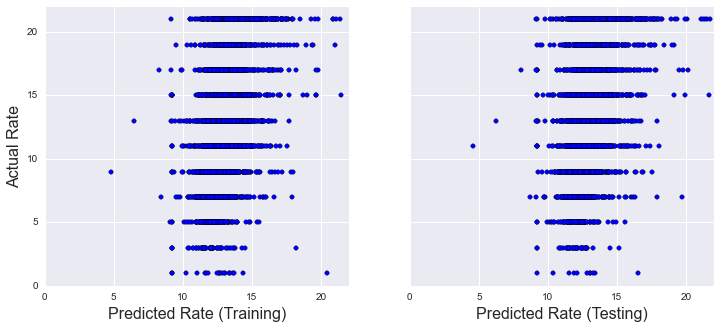

In [56]:
fig, [axL, axR] = plt.subplots(nrows=1, ncols=2, figsize=(12,5), sharey=True);
axL.scatter(pred_train, y_train);
axL.set_xlabel('Predicted Rate (Training)');
axL.xaxis.label.set_fontsize(16);
axL.set_xlim(0,22);
axL.set_ylabel('Actual Rate');
axL.yaxis.label.set_fontsize(16);
axL.set_ylim(0,22);

axR.scatter(pred_test, y_test);
axR.set_xlabel('Predicted Rate (Testing)');
axR.xaxis.label.set_fontsize(16);
axR.set_xlim(0,22);

In [57]:
rf = ensemble.RandomForestRegressor();
rf.fit(x_train[cols_to_use], y_train);
print rf.feature_importances_;

pred_train = rf.predict(x_train[cols_to_use]);
pred_test = rf.predict(x_test[cols_to_use]);

[ 0.12845357  0.33394194  0.1277632   0.14439941  0.22936718  0.0360747 ]


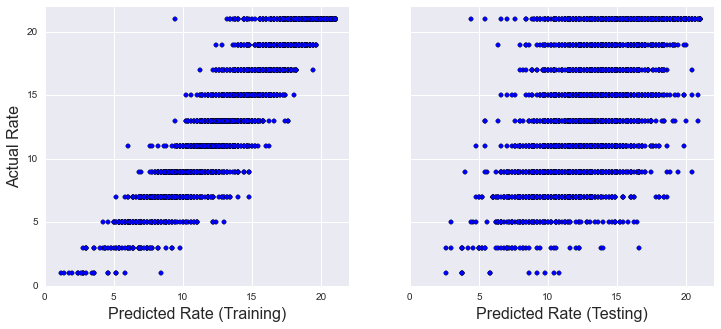

In [58]:
fig, [axL, axR] = plt.subplots(nrows=1, ncols=2, figsize=(12,5), sharey=True);
axL.scatter(pred_train, y_train);
axL.set_xlabel('Predicted Rate (Training)');
axL.xaxis.label.set_fontsize(16);
axL.set_xlim(0,22);
axL.set_ylabel('Actual Rate');
axL.yaxis.label.set_fontsize(16);
axL.set_ylim(0,22);

axR.scatter(pred_test, y_test);
axR.set_xlabel('Predicted Rate (Testing)');
axR.xaxis.label.set_fontsize(16);
axR.set_xlim(0,22);